In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
import random
import seaborn as sns
import pollution

import matplotlib.pyplot as plt
import matplotlib
from tqdm import trange
import tqdm
import os
import imageio.v2 as imageio
import math
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import networkx as nx
import os
import math
import matplotlib.ticker as mtick
import ipywidgets as widgets
from scipy.optimize import minimize_scalar, minimize
from matplotlib.lines import Line2D

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

font = {        'size'   : 20}
params = {'figure.figsize': (10, 5),
          'font.family':'sans-serif',
          'font.sans-serif':'Nimbus Sans'}
mpl.rc('font', **font)
plt.rcParams.update(params)

In [ ]:
N=20
mu_mean = 0.4
D=N//10
R=5
phi=5
L = 50
T=50

mu_m = 0.05
mu_M = (5*mu_mean - mu_m)/4
mu = [mu_m]*(N//5) + [mu_M]*(4*N//5)
np.random.shuffle(mu)
world = pollution.World(L=L,N=N,D=D,phi=5,R=5,M_nu=1,mu=mu)
for t in range(T):
    world.step()

In [ ]:
c = len([a for a in world.agents if a.type=='c'])/N
d = len([a for a in world.agents if a.type=='d'])/N
c_m = len([a for a in world.agents if a.type=='c' and a.mu==mu_m])/N
c_M = len([a for a in world.agents if a.type=='c' and a.mu==mu_M])/N

d_m = len([a for a in world.agents if a.type=='d' and a.mu==mu_m])/N
d_M = len([a for a in world.agents if a.type=='d' and a.mu==mu_M])/N

# print(c)
print("c_m = "+f'{c_m} ', "c_M = " +f'{c_M} ', 'c = '+f'{c}')
print("d_m = "+f'{d_m} ', "d_M = " +f'{d_M} ', 'd = '+f'{d}')
print("a_m = "+f'{c_m+d_m} ', "a_M = " +f'{c_M+d_M} ')

In [ ]:
print("c_m = "+f'{c_m} ', "c_M = " +f'{c-c_m} ', 'c = '+f'{c}')
print("d_m = "+f'{0.2-c_m} ', "d_M = " +f'{0.8-(c-c_m)} ', 'd = '+f'{d}')
print("a_m = "+f'{0.2} ', "a_M = " +f'{0.8} ')

# Ensembles

In [2]:
N=80
mu_mean = 0.8
folder = f'Data/Imitation/Two Costs/N{N}/0{mu_mean*10}'
T=50
D = np.arange(N//10,N,N//10).tolist()
R=5
phi=5
L = 50
runs=200
mu_m=np.arange(0,1.05,0.05)
mu_M=(5*mu_mean - mu_m)/4

pcp = np.zeros((len(D),len(mu_m),runs)) # change in pcp
cc = np.zeros((len(D),len(mu_m),runs)) # clustering
c_rate = np.zeros((len(D),len(mu_m),runs)) # cleaning rate

type_cc = np.zeros((2,2,len(D),len(mu_m),runs)) # cc by [minority, majority] X [C,D]
minority_c_rate = np.zeros((len(D),len(mu_m),runs)) # NUMBER of minority C
                                                # - the types for defectors can be found from
                                                # mD = 0.2N - mC ... etc
                                                # MC = C - mC
for k in trange(runs):
    for i in range(len(D)):
        for j in range(len(mu_m)):
            mu = [mu_m[j]]*(N//5) + [mu_M[j]]*(4*N//5)
            np.random.shuffle(mu)
            world = pollution.World(L=L,N=N,D=D[i],phi=5,R=5,M_nu=1,mu=mu)
            pcp[i,j,k] -= world.per_capita_pollution()
            for t in range(T):
                world.step()
            pcp[i,j,k] += world.per_capita_pollution()
            clusters = world.observe_clusters()
            if len(clusters)>0:
                for c in range(len(clusters)):
                    clusters[0].update(clusters[c])
                cc[i,j,k] = len(clusters[0])/len(world.agents)
                type_cc[:,:,i,j,k] = world.cluster_breakdown(ccs=clusters,
                                                             mu_vals=[mu_m[j],mu_M[j]])
            c_rate[i,j,k] = len([a for a in world.agents if a.type=='c'])
            minority_c_rate[i,j,k] = len([a for a in world.agents if (a.type=='c') and (a.mu==mu_m[j])])
np.savetxt(folder+'pcp.csv',pcp.reshape(len(D)*len(mu_m),runs))
np.savetxt(folder+'cc.csv',cc.reshape(len(D)*len(mu_m),runs))
np.savetxt(folder+'c_rate.csv',c_rate.reshape(len(D)*len(mu_m),runs))
np.savetxt(folder+'type_cc.csv',type_cc.reshape(4*len(D)*len(mu_m),runs))
np.savetxt(folder+'minority_c_rate.csv',minority_c_rate.reshape(len(D)*len(mu_m),runs))

100%|██████████████████████████████████████| 200/200 [9:55:13<00:00, 178.57s/it]


# Figures

In [2]:
N=20
mu_mean = [0.4,0.8]
folder = f'Data/Imitation/Two Costs/N{N}/0'

runs=200
D = np.arange(0.1,1,0.1).tolist()
mu_m=np.arange(0,1.05,0.05)

pcp=np.stack([np.loadtxt(folder+f'{m*10}pcp.csv').reshape((len(D),len(mu_m),runs)) 
              for m in mu_mean])
cc=np.stack([np.loadtxt(folder+f'{m*10}cc.csv').reshape((len(D),len(mu_m),runs)) 
             for m in mu_mean])
c_rate=np.stack([np.loadtxt(folder+f'{m*10}c_rate.csv').reshape((len(D),len(mu_m),runs)) 
                 for m in mu_mean])/N
type_cc=np.stack([np.loadtxt(folder+f'{m*10}type_cc.csv').reshape((2,2,len(D),len(mu_m),runs)) 
                  for m in mu_mean])
minority_c_rate=np.stack([np.loadtxt(folder+f'{m*10}minority_c_rate.csv').reshape((len(D),
                                                                                   len(mu_m),
                                                                                   runs)) 
                          for m in mu_mean])/N

minority_c_rate[0,:,mu_m==0.4,:] *= 0.2
minority_c_rate[1,:,mu_m==0.8,:] *= 0.2

In [3]:
D_corners = np.array([0]+D)+0.05
mu_corners = np.diff(np.array([-0.05]+list(mu_m)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)
mu_mesh,D_mesh = np.meshgrid(mu_corners,D_corners)
mu_grid,D_grid=np.meshgrid(mu_m,D)

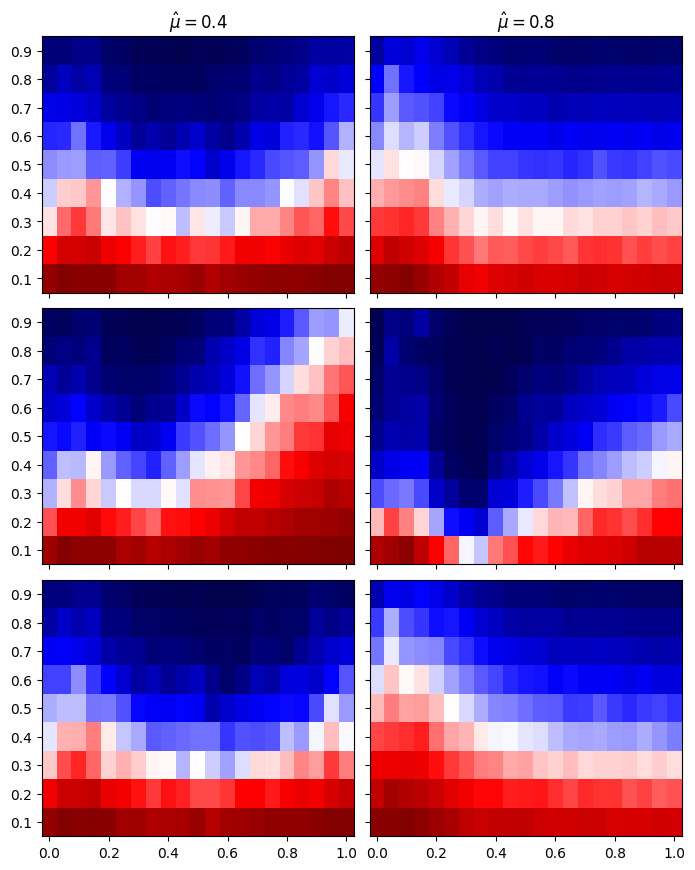

In [4]:
fig,axs=plt.subplots(figsize=(8,10),ncols=2,nrows=3,sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.06)

ims=[0]*3
for i in range(2):
    ims[0]=axs[0,i].pcolormesh(mu_mesh,1-D_mesh,c_rate[i].mean(axis=-1),cmap='seismic_r',vmin=0,vmax=1)
    ims[1]=axs[1,i].pcolormesh(mu_mesh,1-D_mesh,minority_c_rate[i].mean(axis=-1),cmap='seismic_r',vmin=0,vmax=0.2)
    ims[2]=axs[2,i].pcolormesh(mu_mesh,1-D_mesh,
                        (c_rate[i]-minority_c_rate[i]).mean(axis=-1),cmap='seismic_r',vmin=0,vmax=0.8)
    axs[0,i].set_title(r'$\hat{\mu}=$'+f'{mu_mean[i]}')
    
# for j in range(3):
    

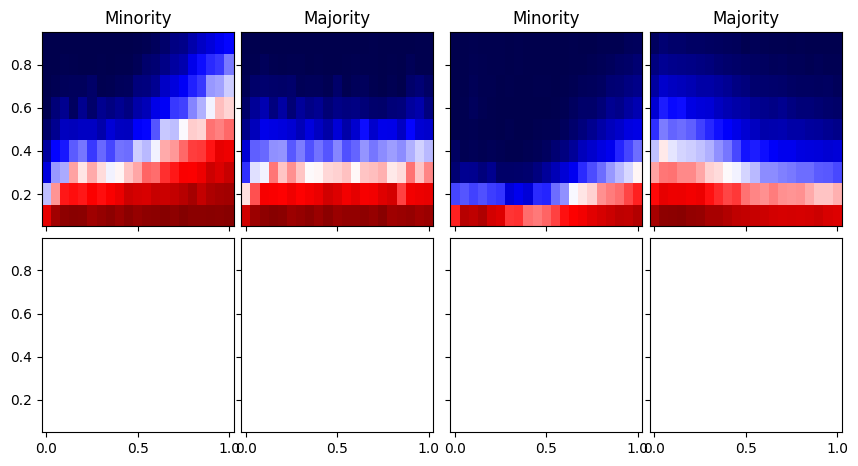

In [9]:
fig,axs=plt.subplots(figsize=(10,5),ncols=5,nrows=2,sharex=True,sharey=True,
                     gridspec_kw=dict(width_ratios=[1,1,0.01,1,1]))
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.06)

ims=[0]*2
for i in range(2):
    axs[i,2].set_visible(False)
    axs[0,3*i].set_title("Minority")
    axs[0,3*i].pcolormesh(mu_mesh,1-D_mesh,minority_c_rate[i].mean(axis=-1),
                          cmap=truncate_colormap(plt.get_cmap('seismic_r'),0,1),vmin=0,vmax=0.2)
#     axs[1,3*i].pcolormesh(mu_mesh,1-D_mesh,0.2-minority_c_rate[i].mean(axis=-1),
#                           cmap=truncate_colormap(plt.get_cmap('seismic'),0.5,1),vmin=0,vmax=0.2)
    
    axs[0,1+3*i].set_title("Majority")
    axs[0,1+3*i].pcolormesh(mu_mesh,1-D_mesh,(c_rate[i]-minority_c_rate[i]).mean(axis=-1),
                          cmap=truncate_colormap(plt.get_cmap('seismic_r'),0,1),vmin=0,vmax=0.8)
#     axs[1,1+3*i].pcolormesh(mu_mesh,1-D_mesh,0.8-(c_rate[i]-minority_c_rate[i]).mean(axis=-1),
#                           cmap=truncate_colormap(plt.get_cmap('seismic'),0.5,1),vmin=0,vmax=0.8)

# axs[0,0].set_title("Minority")
# axs[0,3].set_title("Minority")

## Bigger Figures

In [2]:
N=[20,50,80]
mu_mean = 0.4
folder = f'Data/Imitation/Two Costs/'

runs=200
D = np.arange(0.1,1,0.1).tolist()
mu_m=np.arange(0,1.05,0.05)

pcp=np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}pcp.csv').reshape((len(D),len(mu_m),runs)) 
              for n in N])
cc=np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}cc.csv').reshape((len(D),len(mu_m),runs)) 
             for n in N])
c_rate=np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}c_rate.csv').reshape((len(D),len(mu_m),runs))/n 
                 for n in N])
type_cc=np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}type_cc.csv').reshape((2,2,len(D),len(mu_m),runs)) 
                  for n in N])
minority_c_rate=np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}minority_c_rate.csv').reshape((len(D),
                                                                                   len(mu_m),
                                                                                   runs))/n 
                          for n in N])

minority_c_rate[:,:,mu_m==mu_mean,:] *= 0.2
# minority_c_rate[1,:,mu_m==0.8,:] *= 0.2

D_corners = np.array([0]+D)+0.05
mu_corners = np.diff(np.array([-0.05]+list(mu_m)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)
mu_mesh,D_mesh = np.meshgrid(mu_corners,D_corners)
mu_grid,D_grid=np.meshgrid(mu_m,D)

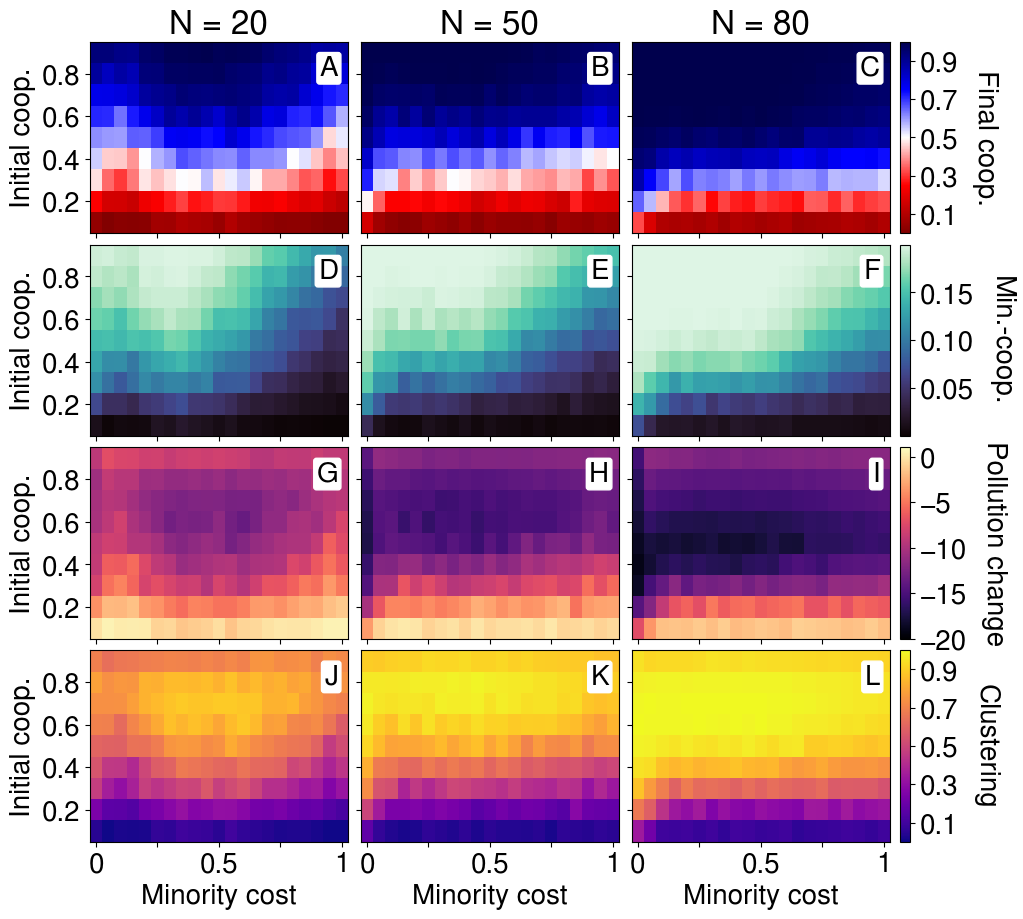

In [67]:
fig,axs=plt.subplots(nrows=4,ncols=3,sharex=True,sharey=True,figsize=(10,10))
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.06)
c_rate_lims = [np.min(c_rate.mean(axis=-1)),np.max(c_rate.mean(axis=-1))]
cc_lims = [np.min(cc.mean(axis=-1)),np.max(cc.mean(axis=-1))]
pcp_lims = [np.min(pcp.mean(axis=-1)),np.max(pcp.mean(axis=-1))]

ims=[0]*4

cm_palette = sns.color_palette("mako", as_cmap=True)
# cm_palette.reverse()
for i in range(3):
    axs[0,i].set_title(f"N = {N[i]}")
    ims[0]=axs[0,i].pcolormesh(mu_mesh,1-D_mesh,np.mean(c_rate[i],axis=-1),
                        cmap='seismic_r',vmin=0,vmax=1)
    ims[1]=axs[1,i].pcolormesh(mu_mesh,1-D_mesh,np.mean(minority_c_rate[i],axis=-1),
                        cmap=cm_palette,vmin=0,vmax=0.2)
    ims[2]=axs[2,i].pcolormesh(mu_mesh,1-D_mesh,np.mean(pcp[i],axis=-1),
                        cmap='magma',vmin=-20,vmax=1)
    ims[3]=axs[3,i].pcolormesh(mu_mesh,1-D_mesh,np.mean(cc[i],axis=-1),vmin=0,vmax=1,cmap='plasma')
    
    axs[-1,i].set_xticks([0,0.25,0.5,0.75,1])
    axs[-1,i].set_xticklabels([0,'',0.5,'',1])
    axs[-1,i].set_xlabel('Minority cost')
    
cb=[0]*4
# c_labels=[r'$\bar{c}(T)$',r'$\bar{c}_m(T)$',r'$\Delta\hat{P}$','$\kappa$']
c_labels=['Final coop.','Min.-coop.','Pollution change','Clustering']
letters=['A','B','C',
         'D','E','F',
         'G','H','I',
         'J','K','L']
ctick_vals=[np.arange(0.1,1,0.2),np.arange(0.05,0.19,0.05),np.arange(-20,1,5),np.arange(0.1,1,0.2)]
for j in range(4):
#     axs[j,2].set_visible(False)
    pos = axs[j,-1].get_position()
    cax = fig.add_axes([pos.xmax+0.01,pos.ymin,
                       0.01,pos.ymax-pos.ymin])    
    cb[j]=fig.colorbar(ims[j],cax=cax,ticks=ctick_vals[j])
    cb[j].set_label(label=c_labels[j],rotation=-90,va='bottom',ha='center',labelpad=10)
#     cb[j].ax.tick_params(labelsize=10)
    axs[j,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[j,0].set_yticklabels([0.2,0.4,0.6,0.8])
    axs[j,0].set_ylabel('Initial coop.')
    for i in range(3):
        axs[j,i].text(0.985,0.825,letters[j*3+i],va='center',ha='right',
                      bbox=dict(boxstyle='round', fc="w",pad=0.1,ec='w'))
        
        
# ax_outer=fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# # plt.xlabel("common X",fontsize='medium')
# plt.ylabel(r"Initial Cooperators, $c(0)$",size='medium')
# plt.xlabel("Minority cost, $\mu_m$",size='medium')
fig.savefig(f"Figures/Imitation/two_cost_mu0{int(mu_mean*10)}.png",bbox_inches='tight')
fig.savefig(f"Figures/Imitation/two_cost_mu0{int(mu_mean*10)}.eps",format='eps',bbox_inches='tight')

## c_m compared to c

In [3]:
N=[20,50,80]
mu_means = [0.4,0.8]
folder = f'Data/Imitation/Two Costs/'

runs=200
D = np.arange(0.1,1,0.1).tolist()
mu_m=np.arange(0,1.05,0.05)

pcp=np.stack([np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}pcp.csv').reshape((len(D),len(mu_m),runs)) 
              for n in N]) for mu_mean in mu_means])
cc=np.stack([np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}cc.csv').reshape((len(D),len(mu_m),runs)) 
             for n in N]) for mu_mean in mu_means])
c_rate=np.stack([np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}c_rate.csv').reshape((len(D),len(mu_m),runs))/n 
                 for n in N]) for mu_mean in mu_means])
type_cc=np.stack([np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}type_cc.csv').reshape((2,2,len(D),len(mu_m),runs)) 
                  for n in N]) for mu_mean in mu_means])
minority_c_rate=np.stack([np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}minority_c_rate.csv').reshape((len(D),
                                                                                   len(mu_m),
                                                                                   runs))/n for n in N])
                          for mu_mean in mu_means])

for i in range(len(mu_means)):
    minority_c_rate[i,:,:,mu_m==mu_means[i],:] *= 0.2

D_corners = np.array([0]+D)+0.05
mu_corners = np.diff(np.array([-0.05]+list(mu_m)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)
mu_mesh,D_mesh = np.meshgrid(mu_corners,D_corners)
mu_grid,D_grid=np.meshgrid(mu_m,D)

In [11]:
print(np.min((minority_c_rate/0.2-c_rate).mean(axis=-1)))

-0.37770000000000004


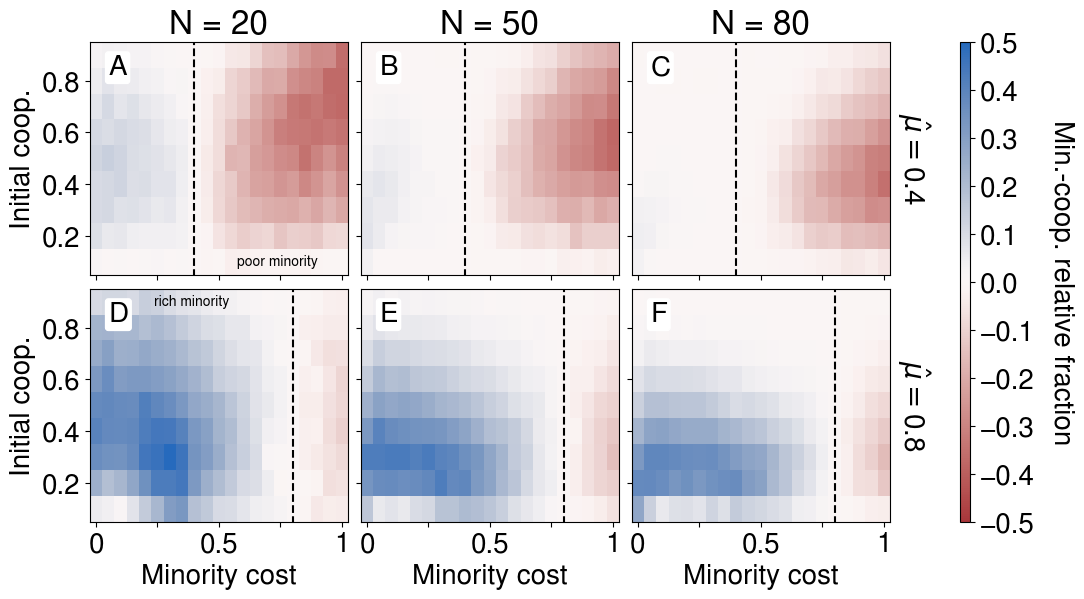

In [9]:
fig,axs=plt.subplots(nrows=2,ncols=3,sharex=True,sharey=True,figsize=(10,6))
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.06)

cmap = sns.color_palette("vlag_r", as_cmap=True)
vmin = min([-0.5,(minority_c_rate/0.2-c_rate).mean(axis=-1).min()])
vmax = max([0.5,(minority_c_rate/0.2-c_rate).mean(axis=-1).max()])
for j in range(len(N)):
    axs[0,j].set_title(f"N = {N[j]}")
    for i in range(len(mu_means)):
        im=axs[i,j].pcolormesh(mu_mesh,1-D_mesh,
                               (minority_c_rate[i,j]/0.2-c_rate[i,j]).mean(axis=-1),
                               cmap=cmap,vmin=vmin,vmax=vmax)
#         im=axs[i,j].pcolormesh(mu_mesh,1-D_mesh,
#                                np.log(minority_c_rate[i,j].mean(axis=-1)/0.2/c_rate[i,j].mean(axis=-1)),
#                                cmap=cmap,vmin=-0.85,vmax=0.85)
        axs[i,j].plot([mu_means[i]]*2,[0,1],'k--')
        axs[i,j].set_ylim([0.05,0.95])
    
    axs[-1,j].set_xticks([0,0.25,0.5,0.75,1])
    axs[-1,j].set_xticklabels([0,'',0.5,'',1])
    axs[-1,j].set_xlabel('Minority cost')
    
cb=[0]*len(mu_means)
letters=['A','B','C',
         'D','E','F']
c_labels=['$\hat{\mu} = $'+f'{mu}' for mu in mu_means]
for i in range(len(mu_means)):
    axs[i,-1].yaxis.set_label_position("right")
    axs[i,-1].set_ylabel(c_labels[i],rotation=-90,ha='center',va='bottom')
    axs[i,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[i,0].set_yticklabels([0.2,0.4,0.6,0.8])
    axs[i,0].set_ylabel('Initial coop.')
    for j in range(3):
        axs[i,j].text(0.05,0.9,letters[i*3+j],va='top',ha='left',
                      bbox=dict(boxstyle='round', fc="w",pad=0.1,ec='w'))
    
axs[0,0].text(0.7375,0.1,'poor minority',fontsize=10,ha='center',va='center')
axs[1,0].text(0.3875,0.9,'rich minority',fontsize=10,ha='center',va='center')
    
ax_outer=fig.add_subplot(111, frameon=False)
pos = ax_outer.get_position()
cax = fig.add_axes([pos.xmax+0.07,pos.ymin,
                    0.01,pos.ymax-pos.ymin]) 
cb=fig.colorbar(im,cax=cax,ticks=np.arange(-0.5,0.6,0.1))
cb.set_label(label='Min.-coop. relative fraction',
             size='medium',rotation=-90,va='bottom',ha='center',labelpad=10)
ax_outer.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# # plt.xlabel("common X",fontsize='medium')
# ax_outer.set_ylabel(r"Initial coop.")
# ax_outer.set_xlabel("Minority cost")
# fig.savefig(f"Figures/Imitation/two_cost_minority_proportions.png",bbox_inches='tight')
fig.savefig(f"Figures/Imitation/two_cost_minority_proportions_text.png",bbox_inches='tight')
fig.savefig(f"Figures/Imitation/two_cost_minority_proportions_text.eps",format='eps',bbox_inches='tight')

In [25]:
vmin

-0.45

In [38]:
vmin = min([-0.5,(minority_c_rate/0.2-c_rate).mean(axis=-1).min()])
print(vmin)

-0.5


In [8]:
c_rate.shape

(2, 3, 9, 21, 200)

In [9]:
c_rate.mean(axis=(2,3,4))

array([[0.60163624, 0.65833704, 0.75343089],
       [0.58796825, 0.71021534, 0.75028042]])

# Ensemble Metrics

In [16]:
N=[20,50,80]
mu_mean = 0.4
folder = f'Data/Imitation/Two Costs/'

runs=200
D = np.arange(0.1,1,0.1).tolist()
mu_m=np.arange(0,1.05,0.05)
c_rate=np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}c_rate.csv').reshape((len(D),len(mu_m),runs))/n 
                 for n in N])
type_cc=np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}type_cc.csv').reshape((2,2,len(D),len(mu_m),runs)) 
                  for n in N])
minority_c_rate=np.stack([np.loadtxt(folder+f'N{n}/0{mu_mean*10}minority_c_rate.csv').reshape((len(D),
                                                                                   len(mu_m),
                                                                                   runs))/n 
                          for n in N])

D_corners = np.array([0]+D)+0.05
mu_corners = np.diff(np.array([-0.05]+list(mu_m)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)
mu_mesh,D_mesh = np.meshgrid(mu_corners,D_corners)
mu_grid,D_grid=np.meshgrid(mu_m,D)

Text(0.5, 0, 'Mobility cost, $\\mu$')

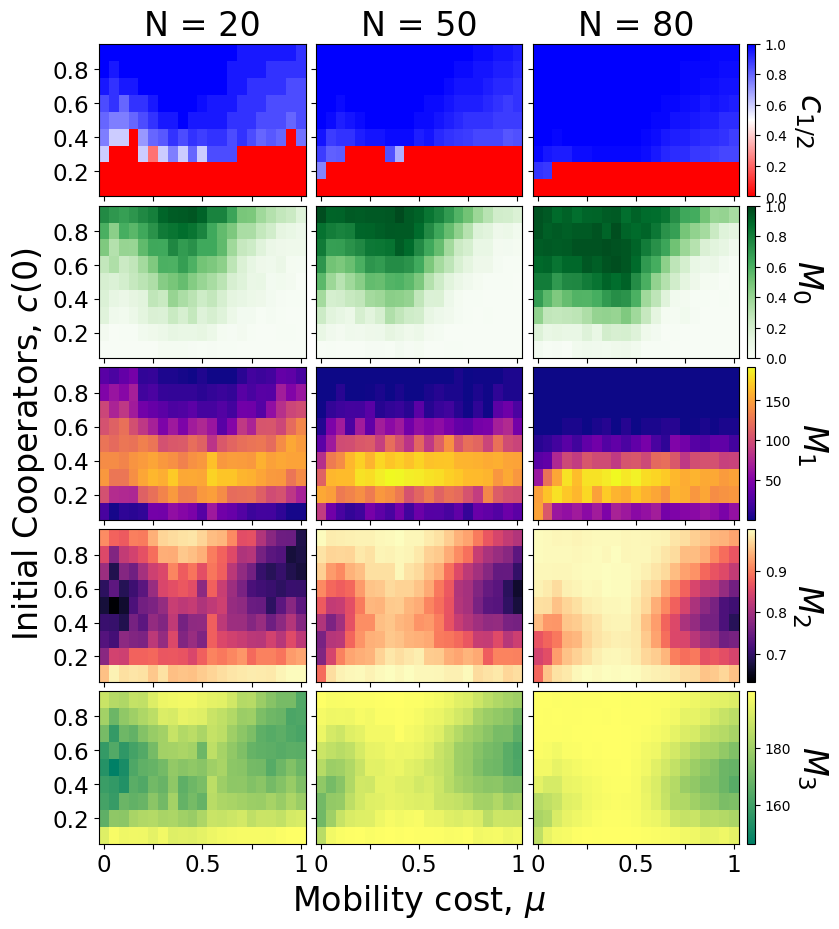

In [18]:
c_norm = c_rate*2-1 # normalise to [-1,1]
c_mean = c_norm.mean(axis=-1)
P1 = np.sum((c_norm-c_mean.reshape((len(N),len(D),len(mu_m),1)))**2,axis=-1)
P2 = (c_norm**2).mean(axis=-1)
P3 = (c_norm**2).sum(axis=-1)
P4 = np.abs(c_norm).sum(axis=-1)
c_med = np.median(c_norm,axis=-1)
mass_c_no = (c_norm==1).sum(axis=-1)/c_norm.shape[-1]

metrics = [np.median(c_rate,axis=-1),mass_c_no,P1,P2,P4]
c_labels = [r'$c_{1/2}$','$M_0$','$M_1$','$M_2$','$M_3$']
cmaps = ['bwr_r','Greens','plasma','magma','summer']
vmins = [m.min() for m in metrics] #[0]*5
vmaxs = [m.max() for m in metrics] #[1,1,190,1,200]
vmins[0:2]=[0]*2
vmaxs[0:2]=[1]*2

fig,axs=plt.subplots(figsize=(8,10),ncols=3,nrows=len(metrics),sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.06)

ims=[0]*len(metrics)
for i in range(3):
    axs[0,i].set_title(f"N = {N[i]}",size='large')
    axs[-1,i].set_xticks([0,0.25,0.5,0.75,1])
    axs[-1,i].set_xticklabels([0,'',0.5,'',1])
    for j in range(len(metrics)):
        ims[j]=axs[j,i].pcolormesh(mu_mesh,1-D_mesh,metrics[j][i],
                               cmap=cmaps[j],vmin=vmins[j],vmax=vmaxs[j])
#         axs[j,i].plot([mu_mean]*2,[0,1],'k--')
#         axs[j,i].set_ylim([min(D_corners),max(D_corners)])

cb=[0]*axs.shape[0]
for j in range(axs.shape[0]):
#     axs[j,2].set_visible(False)
    pos = axs[j,-1].get_position()
    cax = fig.add_axes([pos.xmax+0.01,pos.ymin,
                       0.01,pos.ymax-pos.ymin])    
    cb[j]=fig.colorbar(ims[j],cax=cax)
    cb[j].set_label(label=c_labels[j],size='large',rotation=-90,va='center',ha='center',labelpad=15)
    cb[j].ax.tick_params(labelsize=10)
    axs[j,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[j,0].set_yticklabels([0.2,0.4,0.6,0.8])

ax_outer=fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X",fontsize='medium')
plt.ylabel(r"Initial Cooperators, $c(0)$",size='large')
plt.xlabel("Mobility cost, $\mu$",size='large')
# fig.tight_layout()
# fig.savefig("Figures/Imitation/two_costs_08_c_norm_metrics.png",bbox_inches='tight')